In [2]:
import sys
sys.path.append("../model")
from LSTMModel import LSTM

In [3]:
import datetime
import numpy as np
import pandas as pd
import math
import glob
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [17]:
from sklearn.preprocessing import MinMaxScaler
import torch

In [4]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [5]:
# read all ndvi 
data_path = "/att/nobackup/jli30/workspace/ndvi_MGBrown_notebooks/data/timeseries"
files = glob.glob(os.path.join(data_path, "ndvi*.npy"))
data = np.array([np.load(f) for f in sorted(files)])
data.shape

(230, 52, 75)

In [8]:
# reshape & exclude missing value
ds = data.reshape(230, -1)
ds = np.where(ds!=-3000.0, ds, np.nan)
# generate ndvi timeseries
ndvi_ts = np.nanmean(ds, axis=1)
ndvi_ts.shape

(230,)

In [9]:
# construct datestamps
days = range(1, 365, 16)
s = [str(d).zfill(3) for d in days]
date = []
for year in range(2008, 2018):
    d = [str(year)+t for t in s]
    date.extend(d)

dates = [datetime.datetime.strptime(a, '%Y%j') for a in date]

<AxesSubplot:xlabel='Date'>

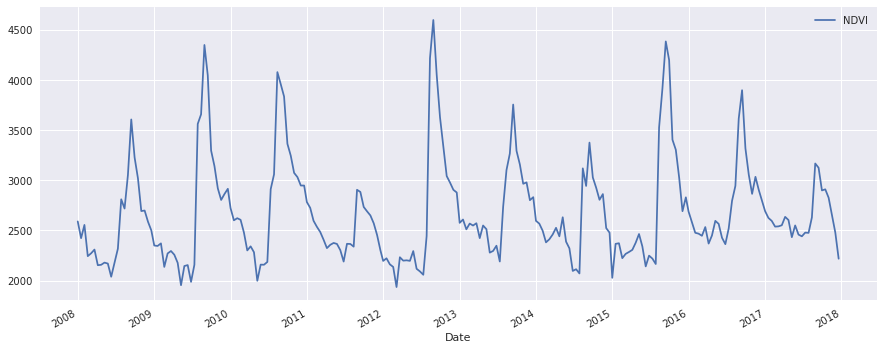

In [10]:
df = pd.DataFrame()
df['Date'] = dates
df['NDVI'] = ndvi_ts
df_p = df.set_index('Date')
df_p.plot(figsize=(15, 6))

##### train the model

In [12]:
## Normalize Data
scaler = MinMaxScaler(feature_range=(-1, 1))
ts_scaled = scaler.fit_transform(ndvi_ts.reshape(-1, 1))

In [13]:
def load_data(data_raw, win):
    data = []
    
    for index in range(len(data_raw)-win):
        data.append(data_raw[index:index+win])
        
    data = np.array(data)
    test_size = int(np.round(0.2*data.shape[0]))
    train_size = data.shape[0]-test_size
        
    x_train = data[:train_size, :-1, :]
    y_train = data[:train_size, -1, :]
        
    x_test = data[train_size:, :-1, :]
    y_test = data[train_size:, -1, :]
        
    return [x_train, y_train, x_test, y_test]

In [14]:
window=20
x_train, y_train, x_test, y_test = load_data(ts_scaled, window)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (168, 19, 1)
y_train.shape =  (168, 1)
x_test.shape =  (42, 19, 1)
y_test.shape =  (42, 1)


In [18]:
# make training and test sets in torch
x_train_t = torch.from_numpy(x_train).type(torch.Tensor)
y_train_t = torch.from_numpy(y_train).type(torch.Tensor)
x_test_t = torch.from_numpy(x_test).type(torch.Tensor)
y_test_t = torch.from_numpy(y_test).type(torch.Tensor)

In [19]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

model = LSTM(input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers = num_layers)
lose_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [20]:
# Train model

num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim = window-1

for t in range(num_epochs):
    # Initialise hidden state
    # SKIP
    
    # Forward pass
    y_train_pred = model(x_train_t)
    
    loss = lose_fn(y_train_pred, y_train_t)
    
    if t%10 == 0 and t != 0:
        print("Epoch:  ", t, "MSE:  ", loss.item())
    
    hist[t] = loss.item()
    
    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()
    
    # Back pass
    loss.backward()
    
    # Update parameter
    optimiser.step()

Epoch:   10 MSE:   0.13534536957740784
Epoch:   20 MSE:   0.06626211851835251
Epoch:   30 MSE:   0.037291109561920166
Epoch:   40 MSE:   0.03462826833128929
Epoch:   50 MSE:   0.031697001308202744
Epoch:   60 MSE:   0.028002697974443436
Epoch:   70 MSE:   0.023881612345576286
Epoch:   80 MSE:   0.02053256146609783
Epoch:   90 MSE:   0.020529862493276596


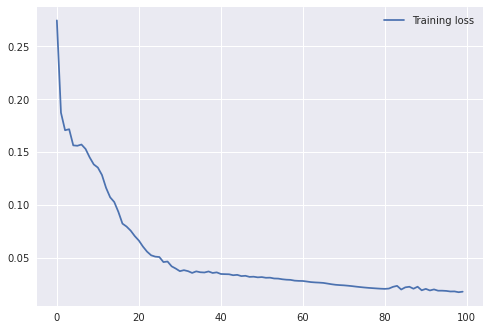

In [21]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [23]:
# scale back
y_train_pred_o = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train_o = scaler.inverse_transform(y_train_t.detach().numpy())
y_test_pred = model(x_test_t)
y_test_pred_o = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test_o = scaler.inverse_transform(y_test_t.detach().numpy())

In [24]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_o[:,0], y_train_pred_o[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_o[:,0], y_test_pred_o[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 177.99 RMSE
Test Score: 203.05 RMSE


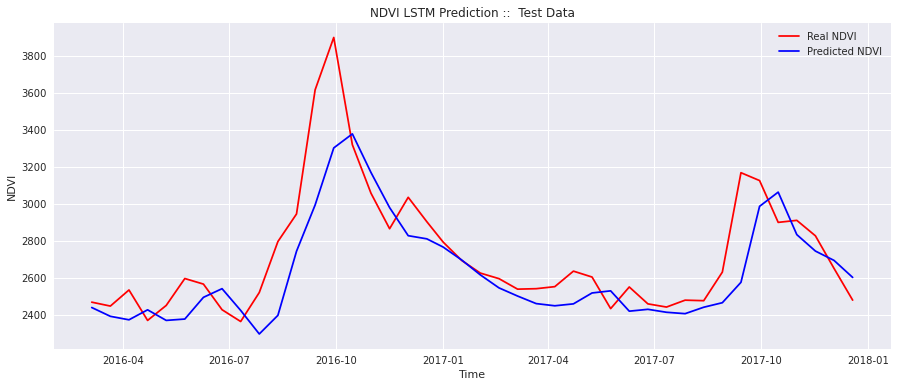

In [26]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_p[len(df_p)-len(y_test_o):].index, y_test_o, color = 'red', label = 'Real NDVI')
axes.plot(df_p[len(df_p)-len(y_test_o):].index, y_test_pred_o, color = 'blue', label = 'Predicted NDVI')

plt.title('NDVI LSTM Prediction ::  Test Data')
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.legend()
plt.show()